# This is a notebook for testing my implementation of LSPI

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

from scipy.optimize import minimize

In [3]:
#env = gym.make('CartPole-v0')
env = gym.make("MountainCarContinuous-v0")
#env = gym.make("Pendulum-v0")
#env = gym.make("NChain-v0")
#env = gym.make("Acrobot-v1")
env.reset()

array([-0.4143957,  0.       ])

In [ ]:
env.action_space.sample()

In [ ]:
env.observation_space.sample()

# Implementation

In [90]:
def LSPI(basis_functions, gamma, epsilon, w, env, method = "discrete"):
    '''
    Compute the parameters of the policy, w, using the LSPI algorithm.
    
    Inputs:
    sample: list of tuples of the form (s,a,r,s')
    basis_functions: list of basis functions
    gamma: float, discount factor
    epsilon: float, convergence threshold
    w: intial policy parameter vector
    
    Outputs:
    w: the converged policy paramters
    '''
    w0 = []
    # for mountain car, use 1000 trials with 20 timesteps
    samples = generate_samples(env, 1000, 20)
    #while True:
    for i in tqdm(range(100)):
        w_prev = w
        #w = LSTDQ(samples, basis_functions, gamma, w, env)
        w = LSTDQ_OPT(samples, basis_functions, gamma, w, env, method = method)
        
        
        if converged(w, w_prev, epsilon):
            break 
        else:
            w_prev = w
        w0.append(w[0])
        print w[0]
    return w, w0

def converged(w, w_prev, epsilon):
    '''
    Determines if the policy parameters have converged based
    on whether or not the norm of the difference of w
    is less than the threshold epsilon.
    
    Inputs:
    w: a policy parameter vector
    w_prev: the policy parameter vetor from a previous iteration.
    epsilon: float, convergence threshold
    '''
    return np.linalg.norm(w - w_prev) < epsilon

def LSTDQ(samples, basis_functions, gamma, w, env, method="discrete"):
    '''
    Simple version of LSTDQ
    '''
    k = len(basis_functions)
    #A = np.zeros((k,k)), this might not have an inverse, use the next line instead
    A = np.identity(k) * 0.01
    b = np.zeros(k)
    
    #samples[np.random.choice(len(samples), 100, replace=False)]
    
    for s, a, r, sp in samples:
        phi = compute_phi(s,a, basis_functions)
        phi_p = compute_phi(sp, get_policy_action(sp, w, basis_functions, env, method), basis_functions)

        A += np.outer(phi, (phi - gamma*phi_p))
        b = b + phi*r
    
    
    w = np.dot(np.linalg.inv(A),b)
    return w
    
    

    
    
def LSTDQ_OPT(samples, basis_functions, gamma, w, env, sigma=0.1, method = "discrete" ):
    '''
    A faster version of LSTDQ. Computes an approximation of the policy parameters based
    on the LSTDQ-OPT algorithm presented in the paper.
    
    Inputs:
    sample: list of tuples of the form (s,a,r,s')
    basis_functions: list of basis functions
    gamma: float, discount factor
    epsilon: float, convergence threshold
    w: intial policy parameter vector
    
    sigma: small positive float.
    '''
    k = len(basis_functions)
    B = np.identity(k) * float(1/sigma)
    b = np.zeros(k)
    
    for s, a, r, sp in samples:
        phi = compute_phi(s,a, basis_functions)
        phi_p = compute_phi(sp, get_policy_action(sp, w, basis_functions, env, method), basis_functions)

        # Some computations that can be reused in the computation
        Bphi = np.dot(B, phi)
        phi_t =  (phi - gamma*phi_p).T
        

        top = np.dot(np.outer(Bphi, phi_t), B)
        bottom = 1 + np.dot(phi_t, Bphi)
        B = B - top/bottom
        
        b = b + phi*r
    
    w = np.dot(B,b)
        
        
    return w
       

def compute_phi(s,a, basis_functions):
    '''
    Computes the vector ϕ(s,a) according to the basis function ϕ_1...ϕ_k
    
    Inputs:
    s: state
    a: action
    basis_functions: list of basis functions that operate on s and a
    
    Outputs:
    ϕ(s,a), a vector where each entry is the result of one of the basis functions.
    '''

    phi= np.array([bf(s,a) for bf in basis_functions])
    return phi
    
    
def get_policy_action(s,w, basis_functions, env, method = "discrete"):
    '''
    Computes the best action for the current parameterized policy 
    according to the provided method (discrete, continuous, or continuous-discretized)
    
    Inputs:
    s: state
    w: parameters for policy
    basis_functions: list of basis functions that operate on states and actions
    env: gym environment
    method: string, 
    '''
    if method == "discrete":
        return get_policy_action_discrete(s,w,basis_functions,env)
    if method == "continuous":
        return get_policy_actions_continuous(s, w, basis_functions, env)
    if method == "continuous-discretized":
        return get_policy_actions_continuous_discretized(s, w, basis_functions, env, n_discretizations=10)
    
def get_policy_action_discrete(s, w, basis_functions, env):
    '''
    For discrete action spaces. Given a parameterization for the policy,
    reconstruct the policy and querery it to get 
    the optimal action for state s. That is,
    the argmax over actions of ϕ(s,a).w
    
    Inputs:
    s: state
    w: policy parameters
    basis_functions: the basis functions that are used in the model
    
    Outputs:
    action a that the policy says is best
    '''
    a_max = None
    max_score = float("-inf")
    
#    action_space = [0,1,2] # for cart pole, this is [0,1]
    action_space = [0,1]
    # Search action space for most valuable action
 
    #TODO:  use sympy for grad desc
    for a in action_space:
        score = np.dot(compute_phi(s,a, basis_functions), w)
        # update if we found something better
        if score > max_score:
            max_score = score
            a_max = a

    return a_max    
    
    
def get_policy_actions_continuous_discretized(s, w, basis_functions, env, n_discretizations=10):
    '''
    For continuous action spaces, discretize the space and
    given a parameterization for the policy, reconstruct the policy and querery it to get 
    the optimal action for state s. That is,
    the argmax over actions of ϕ(s,a).w
    
    Inputs:
    s: stateget_policy_action
    w: policy parameters
    basis_functions: the basis functions that are used in the model
    n_discretizations: the number of chunks to split the continuous space into
       
    
    Outputs:
    action a that the policy says is best
    '''
    
    a_max = None
    max_score = float("-inf")
    
    # Discretize the continuous space into n_discretizations chunks
    action_space = np.linspace(env.action_space.low[0], env.action_space.high[0], n_discretizations)

    for a in action_space:
        score = np.dot(compute_phi(s, a, basis_functions), w)
       
        # update if we found something better
        if score > max_score:
            max_score = score
            a_max = a
            
    return a_max



def get_policy_actions_continuous(s,w,basis_functions, env):
    '''
    For continuous action spaces. Given a parameterization for the policy,
    reconstruct the policy and querery it to get 
    the optimal action for state s. That is,
    the argmax over actions of ϕ(s,a).w
    
    Inputs:
    s: stateget_policy_action
    w: policy parameters
    basis_functions: the basis functions that are used in the model
       
    
    Outputs:
    action a that the policy says is best
    '''
    f = lambda a: np.dot(compute_phi(s, a, basis_functions), w)
    x0 = 0
    #mountain_car_bounds = []
    result = minimize(f, x0, method='L-BFGS-B', options={'xtol': 1e-8, 'disp': True}, bounds = [(-1,1)])
    return result.x

def get_cartpole_basis_functions_v1():
    bf1 = lambda s,a:a
    bf2 = lambda s,a:s[0]
    bf3 = lambda s,a:s[1]
    bf4 = lambda s,a:s[2]
    bf5 = lambda s,a:s[3]
    bfs = [bf1,bf2,bf3,bf4,bf5]
    return bfs
   
def get_cartpole_basis_functions_v2():
    '''
    Returns a list of basis functions that seem 
    to work well for the simplified (no singularity, starting above the horizon)
    cartpole problem.
    
    Note: this one seems to work the best so far.
    '''
    s1 = np.array([1,1,1,1])
    s2 = np.array([0,0,0,0])
    s3 = np.array([1,0,1,0])

    bf1 = lambda s,a: 1

    bf2 = lambda s,a: int(a==0)*np.exp( - np.linalg.norm(s-s1)/2.0)
    bf3 = lambda s,a: int(a==1)*np.exp( - np.linalg.norm(s-s1)/2.0)

    bf4 = lambda s,a: int(a==0)*np.exp( - np.linalg.norm(s-s2)/2.0)
    bf5 = lambda s,a: int(a==1)*np.exp( - np.linalg.norm(s-s2)/2.0)

    bf6 = lambda s,a: int(a==0)*np.exp( - np.linalg.norm(s-s3)/2.0)
    bf7 = lambda s,a: int(a==1)*np.exp( - np.linalg.norm(s-s3)/2.0)
    
    
    bfs = [bf1,bf2, bf3, bf4, bf5, bf6, bf7]
    
    return bfs


def get_cartpole_basis_functions_v3():

    s1 = np.array([-1,-1,0,0])
    s2 = np.array([-0.5,-1,0,0])
    s3 = np.array([-0.1,-1,0,-0.5])
    s4 = np.array([0,0,0,0])
    s5 = np.array([0.1,1,0,0])
    s6 = np.array([0.5,0.5,0,-0.5])
    s7 = np.array([1,0,0,0])

    bf1 = lambda s,a: 1

    bf2 = lambda s,a: int(a==0)*np.exp( - np.linalg.norm(s-s1)/2.0)
    bf3 = lambda s,a: int(a==1)*np.exp( - np.linalg.norm(s-s1)/2.0)

    bf4 = lambda s,a: int(a==0)*np.exp( - np.linalg.norm(s-s2)/2.0)
    bf5 = lambda s,a: int(a==1)*np.exp( - np.linalg.norm(s-s2)/2.0)

    bf6 = lambda s,a: int(a==0)*np.exp( - np.linalg.norm(s-s3)/2.0)
    bf7 = lambda s,a: int(a==1)*np.exp( - np.linalg.norm(s-s3)/2.0)
    
    bf8 = lambda s,a: int(a==0)*np.exp( - np.linalg.norm(s-s4)/2.0)
    bf9 = lambda s,a: int(a==1)*np.exp( - np.linalg.norm(s-s4)/2.0)
    
    bf10 = lambda s,a: int(a==0)*np.exp( - np.linalg.norm(s-s5)/2.0)
    bf11 = lambda s,a: int(a==1)*np.exp( - np.linalg.norm(s-s5)/2.0)
    
    bf12 = lambda s,a: int(a==0)*np.exp( - np.linalg.norm(s-s6)/2.0)
    bf13 = lambda s,a: int(a==1)*np.exp( - np.linalg.norm(s-s6)/2.0)
    
    bf14 = lambda s,a: int(a==0)*np.exp( - np.linalg.norm(s-s7)/2.0)
    bf15 = lambda s,a: int(a==1)*np.exp( - np.linalg.norm(s-s7)/2.0)

    bfs = [bf1,bf2,bf3,bf4, bf5, bf6, bf7, bf8, bf9, bf10, bf11, bf12, bf13, bf14, bf15]
    return bfs
    
    
def get_cartpole_basis_functions_v4():
    bf1 = lambda s,a: 1
    bf2 = lambda s,a: a
    bf3 = lambda s,a: int(a==0)*s[0]
    bf4 = lambda s,a: int(a==0)*s[1]
    bf5 = lambda s,a: int(a==0)*s[2]
    bf6 = lambda s,a: int(a==0)*s[3]
    bf7 = lambda s,a: int(a==1)*s[0]
    bf8 = lambda s,a: int(a==1)*s[1]
    bf9 = lambda s,a: int(a==1)*s[2]
    bf10 = lambda s,a: int(a==1)*s[3]
    return [bf1,bf2,bf3,bf4,bf5, bf6, bf7, bf8, bf8, bf10]

    
def get_continuous_mt_car_basis_functions():
    '''
    Define some basis functions and return them in a list
    '''

    bf1 = lambda s,a: 1
    bf2 = lambda s,a: s[0]
    bf3 = lambda s,a: a
    bf4 = lambda s,a: a*s[0]*s[0]
    bf5 = lambda s,a: a*s[0]*s[0]*s[0]
    bf6 = lambda s,a: a*s[1]
    bf7 = lambda s,a: a*s[1]*s[1]
    bf8 = lambda s,a: a*s[1]*s[1]*s[1]
    bf9 = lambda s,a: a*s[0]*s[1]
    bf10 = lambda s,a: a*s[0]*s[0]*s[1]*s[1]

    return [bf1,bf2,bf3,bf4,bf5,bf6,bf7,bf8,bf9,bf10]

def get_non_linear_mt_car_basis_functions():
    '''
    Define some basis functions and return them in a list
    '''

    bf1 = lambda s,a: 1
    bf2 = lambda s,a: s[0]
    bf3 = lambda s,a: a
    bf4 = lambda s,a: (a**5 + a**2 -a)*s[0]*s[0]
    bf5 = lambda s,a: (a**5 + a**2 -a)*s[0]*s[0]*s[0]
    bf6 = lambda s,a: (a**5 + a**2 -a)*s[1]
    bf7 = lambda s,a: (a**5 + a**2 -a)*s[1]*s[1]
    bf8 = lambda s,a: (a**5 + a**2 -a)*s[1]*s[1]*s[1]
    bf9 = lambda s,a: (a**5 + a**2 -a)*s[0]*s[1]
    bf10 = lambda s,a: (a**5 + a**2 -a)*s[0]*s[0]*s[1]*s[1]

    return [bf1,bf2,bf3,bf4,bf5,bf6,bf7,bf8,bf9,bf10]


def quadratic(i,j,a_ind,a,s):
    return int (a == a_ind)*s[i]*s[j]

def get_double_pend_features():
    
    bfs = []
    indices = [0,1,2]
    for a_ind in [0,1,2]:
        for i in range(3):
            for j in range(3):


                f = lambda s,a,i=i,j=j, a_ind=a_ind: quadratic(i,j,a_ind, a,s)
                bfs.append(f)
    return bfs
    
def generate_samples(env, n_samples, n_steps=100):
    samples = []
    print env.reset()
    for i in range(n_samples):
        env.reset()
        for j in range(n_steps):
            #s = list(env.env.state)
            s= env.env.state
            a = env.action_space.sample()
            
            sp,r, _,_ = env.step(a)
            
            sample = (s, a, r, sp)
            samples.append(sample)

    return np.array(samples)
    

In [91]:
#bfs = get_cartpole_basis_functions_v2()
#bfs = get_double_pend_features()
#bfs = get_continuous_mt_car_basis_functions()
bfs = get_non_linear_mt_car_basis_functions()
gamma = 0.95
epsilon = 0.01
k = len(bfs) # the number of basis functions will be the size of parameter vector w

w = np.zeros(k)
w_est, w0 = LSPI(bfs, gamma, epsilon, w, env, method = "continuous")
print w_est



[-0.50189851  0.        ]














  0%|          | 0/100 [00:00<?, ?it/s]/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:235: OptimizeWarning: Unknown solver options: xtol























  1%|          | 1/100 [00:13<22:24, 13.58s/it]

-0.306826083579














  2%|▏         | 2/100 [02:24<1:19:39, 48.77s/it]

-0.891262131788


[ -8.92043845e-01   4.70597631e-01  -4.04382734e-02  -7.01970863e-01
  -8.20422584e-01   6.17042487e-01  -2.67539412e-03   3.70708135e-05
  -3.07595949e-01  -6.19787326e-04]


In [ ]:
method = "continuous"
num_steps = []
for i_episode in range(100):
    observation = env.reset()
    print "--------"
    t = 0
    actions = []
    while True:
        t+=1
        env.render()
        action = get_policy_action(env.env.state, w_est, bfs, env, method = method)
        #action = env.action_space.sample()
        #print type(action)
        #actions.append([action])
        if method == "continuous":
            action = [action[0]]
        #print action
        observation, reward, done, info = env.step(action)
        #print observation
        if done:
            print "reward:",reward
            num_steps.append(t)
            print("Episode finished after {} timesteps".format(t+1))
            break

--------


/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:235: OptimizeWarning: Unknown solver options: xtol


reward: 99.9300511185
Episode finished after 217 timesteps
--------
reward: 99.9304054133
Episode finished after 247 timesteps
--------
reward: 99.9298673892
Episode finished after 168 timesteps
--------
reward: 99.9297468068
Episode finished after 233 timesteps
--------
reward: 99.9300511185
Episode finished after 218 timesteps
--------
reward: 99.9300511185
Episode finished after 218 timesteps
--------
reward: 99.9300511185
Episode finished after 167 timesteps
--------
reward: 99.9300511185
Episode finished after 165 timesteps
--------
reward: 99.9300511185
Episode finished after 238 timesteps
--------
reward: 99.9297757843
Episode finished after 166 timesteps
--------
reward: 99.9297211327
Episode finished after 130 timesteps
--------
reward: 99.9300511185
Episode finished after 166 timesteps
--------
reward: 99.9298423685
Episode finished after 166 timesteps
--------
reward: 99.9299017234
Episode finished after 166 timesteps
--------
reward: 99.9300511185
Episode finished after 167

# Function Optimization

In [ ]:
env.reward_range

In [ ]:
def fun(x):
    return (x+3)*(x+3)

In [ ]:
x0 = 0
result = minimize(f, x0, method='L-BFGS-B', options={'xtol': 1e-8, 'disp': True}, bounds = [(-1,1)])

In [ ]:
f = lambda a: np.dot(compute_phi(observation, a, get_continuous_mt_car_basis_functions()), w_est)

In [ ]:
f(0)

In [15]:
env.action_space.high

array([ 1.])

In [ ]:
env.action_space.n

# Function generation

In [ ]:
def freeze(i,a,s):
    return s[i]
    
    
fs = []
indices = [0,1,2]
for i in range(3):
    
    f = lambda s,a,i = i: freeze(i,a,s)
    fs.append(f)

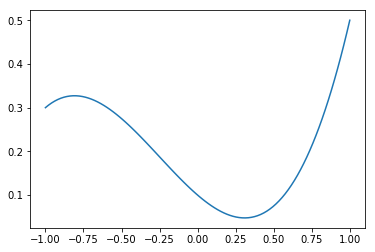

In [86]:
f = lambda x: (0.5*x**3) - (0.1*(x-1)**3)
X = np.linspace(-1,1, 100)
plt.plot(X,f(X))

In [ ]:
(0.5*a**3) - (0.1*(a-1)**3)